<a href="https://colab.research.google.com/github/TimWhiting/robot_pose_generator/blob/master/RobotPoseGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. Define the Generator and Discriminator

In [0]:
!pip install torch==1.1.0
!pip install torchvision==0.3.0
import sys
print(sys.version) # python 3.6
import torch
import torch.nn as nn
import torchvision.datasets
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.utils as vutils
print(torch.__version__) 

%matplotlib inline
import matplotlib.pyplot as plt
import os, time

import itertools
import pickle
import imageio
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from tqdm import tqdm

# You can use whatever display function you want. This is a really simple one that makes decent visualizations
def show_imgs(x, new_fig=True):
    grid = vutils.make_grid(x.detach().cpu(), nrow=8, normalize=True, pad_value=0.3)
    grid = grid.transpose(0,2).transpose(0,1) # channels as last dimension
    if new_fig:
        plt.figure()
    plt.imshow(grid.numpy())

     |████████████████████████████████| 676.9MB 26kB/s 
ERROR: torchvision 0.4.1+cu100 has requirement torch==1.3.0, but you'll have torch 1.1.0 which is incompatible.
  Found existing installation: torch 1.3.0+cu100
    Uninstalling torch-1.3.0+cu100:
      Successfully uninstalled torch-1.3.0+cu100
     |████████████████████████████████| 2.6MB 2.6MB/s 
  Found existing installation: torchvision 0.4.1+cu100
    Uninstalling torchvision-0.4.1+cu100:
      Successfully uninstalled torchvision-0.4.1+cu100
3.6.8 (default, Oct  7 2019, 12:59:55) 
[GCC 8.3.0]
1.1.0


## Defining the neural networks

In [0]:
# helper function to initialize the weights using a normal distribution. 
# this was done in the original work (instead of xavier) and has been shown
# to help GAN performance
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [0]:
class Generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 3, 4, 2, 1)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = torch.tanh(self.deconv5(x))

        return x

In [0]:
class Discriminator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super().__init__()
        self.conv1 = nn.Conv2d(3, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, d*8, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(d*8)
        self.conv5 = nn.Conv2d(d*8, 1, 4, 1, 0)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x = torch.sigmoid(self.conv5(x))

        return x

In [0]:
#####
# instantiate a Generator and Discriminator according to their class definition.
#####
D = Discriminator()
G = Generator()
# print(D)
# print(G)

Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1))
)
Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, m

## Testing the neural networks (forward pass)

In [0]:
# A small batch of 2 samples, random noise.
z = torch.randn(2, 100).view(-1,100,1,1)
x_gen = G(z)
#notice that the generated value is a batch of 2 images
x_gen.shape

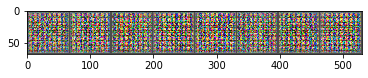

In [0]:
z = torch.randn(8, 100).view(-1,100,1,1).cuda()
G = G.cuda()
show_imgs(G(z))

In traditional deep learning, you measure performance by looking at the loss value. In GANs, this does not work well because we are performing a Min-Max and the loss values may not be intuitively lower when the network is doing well. 

So, performance must be measured qualitatively, by looking at images. Therefore, you can sample random $z$ vectors every pass through the network to see how "novel" the generation is becoming. And you can also sample a single $z$ vector that is passed through the network every time to see how a single example progresses during training. 

In [0]:
fixed_z_ = torch.randn((5 * 5, 100)).view(-1, 100, 1, 1)    # fixed noise
fixed_z_ = Variable(fixed_z_.cuda(), requires_grad=False)

# 3. Now to train your GAN

We introduced and defined the generator G, the discriminator D, and the dataloader which will give us minibatches of real data. 

To recap the basic idea of the min-max / adversarial game:
* The Generator and Discriminator have competing objectives, they are "adversaries".
* The Discriminator wants to assign high probability to real images and low probability to generated (fake) images
* The Generator wants its generated images to look real, so wants to modify its outputs to get high scores from the Discriminator
* We will optimize both alternatingly, with SGD steps (as before): optimize $\theta_D$ the weights of $D(x, \theta_D)$, and  $\theta_G$ the weights of $G(z, \theta_G)$.
* Final goal of the whole min-max game is for the Generator to match the data distribution: $p_G(x) \approx p_{data}(x)$.


Now what are the objective functions for each of them? As mentioned in the introduction, the objective for the discriminator is to classify the real images as real, so $D(x) = 1$, and the fake images as fake, so $D(G(z))=0$.
This is a typical binary classification problem which calls for the binary cross-entropy (BCE) loss, which encourages exactly this solution.

For G we just try to minimize the same loss that D maximizes. See how G appears inside D? This shows how the output of the generator G is passed into the Discriminator to compute the loss.


This is the optimization problem:

$$
\min _{G} \max _{D} V(D, G)=\mathbb{E}_{\boldsymbol{x} \sim p_{\text { data }}(\boldsymbol{x})}[\log D(\boldsymbol{x})]+\mathbb{E}_{\boldsymbol{z} \sim p_{\boldsymbol{z}}(\boldsymbol{z})}[\log (1-D(G(\boldsymbol{z})))]
$$

We will do a single SGD step alternatingly to maximize D, then minimize G.
In fact for G we use a modified (non-saturing) loss $-\log D(G(z))$. Different modifications of the loss and the relation to the distance between distributions $p_{data}$ and $p_{G}$ became a topic of research over the last years.

BCE takes care of the log, you won't manually compute any Log values


In [0]:
# Reset networks
G = Generator(128)
D = Discriminator(128)
G.weight_init(mean=0.0, std=0.02)
D.weight_init(mean=0.0, std=0.02)
G = G.cuda()
D = D.cuda()

# Binary Cross Entropy loss
BCE_loss = nn.BCELoss()

# Adam optimizer
G_optimizer = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

In [0]:
num_iter = 0
collect_x_gen = []
for epoch in range(train_epoch):
    D_losses = []
    G_losses = []
    epoch_start_time = time.time()
    for x_, _ in tqdm(data_loader):
        # train discriminator D
        D.zero_grad()

        mini_batch = x_.size()[0]

        #####
        # create y_real_ and y_fake_ tensors you will use in your BCE loss to push probabilities 
        # in the proper direction
        # y_real_ will be a tensor of all ones, because you want whatever is output by the generator
        # to be more likely to be real and you want the discriminator to recognize real images
        # y_fake_ then is a tensor of all zeros, because you want the discriminator to recognize fake images
        #####
        y_real_ = torch.ones(mini_batch)
        y_fake_ = torch.zeros(mini_batch)

        x_, y_real_, y_fake_ = Variable(x_.cuda()), Variable(y_real_.cuda()), Variable(y_fake_.cuda())
        
        #####
        # pass x_ through the decoder to get D_result
        # you will need to squeeze() the output before passing it to BCE_loss
        # compute D_real_loss using BCE_loss and the proper y tensor from above
        # you are trying to make the discriminator recognize the real image properly
        #####
        D_result = D(x_).squeeze()
        D_real_loss = BCE_loss(D_result,y_real_)

        #####
        # sample a z vector (remember to view(-1,100,1,1))
        # pass the z vector to the GPU and through your generator
        # this will create G_result
        #####
        z = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_result = G(z)

        #####
        # pass G_result through the discriminator and get D_result
        # you will need to squeeze() the output of the discriminator
        # compute D_fake_loss for the generated images by using BCE_loss and the proper y_tensor
        # you are trying to make the discriminator recognize the fake image properly
        # reduce D_fake_loss to the mean value
        #####
        D_result = D(G_result).squeeze()
        D_fake_loss = BCE_loss(D_result, y_fake_)

        #####
        # sum D_real_loss and D_fake_loss to get D_train_loss
        # compute the gradients
        # step the optimizer
        #####
        D_train_loss = D_real_loss + D_fake_loss
        D_train_loss.backward()
        D_optimizer.step()

        D_losses.append(D_train_loss.item())

        # train generator G
        G.zero_grad()

        #####
        # sample a z vector (viewed properly) and pass it to the GPU and through the generator
        # compute the discriminated value of the generated image, properly squeezing the output
        # get G_train_loss by using BCE_loss and the proper y_tensor
        # you are trying to make the generator generate real images
        # compute the gradients
        # step the optimizer
        #####
        z = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
        G_train_loss = BCE_loss(D(G(z)).squeeze(),y_real_)
        G_train_loss.backward()

        G_losses.append(G_train_loss.item())
        G_optimizer.step()

        num_iter += 1

    # generate a fixed_z_ image and save
    fixed_z_ = torch.randn((mini_batch, 100)).view(-1, 100, 1, 1).cuda()
    x_gen = G(fixed_z_)
    collect_x_gen.append(x_gen.detach().clone())
    epoch_end_time = time.time()
    per_epoch_ptime = epoch_end_time - epoch_start_time

    # print out statistics
    print('[%d/%d] - ptime: %.2f, loss_d: %.3f, loss_g: %.3f' % ((epoch + 1), train_epoch, per_epoch_ptime, torch.mean(torch.FloatTensor(D_losses)),
                                                              torch.mean(torch.FloatTensor(G_losses))))
    show_imgs(x_gen)

# A demo of a state of the art GAN and "painting" with them in your browser:

https://gandissect.csail.mit.edu

By our colleagues at the MIT-IBM Watson AI Lab.


# Where to go from here
* Use a more exciting datasets - check out [the pytorch torchvision.datasets](https://pytorch.org/docs/stable/torchvision/datasets.html) to get started quickly.
* The [original GAN paper](https://papers.nips.cc/paper/5423-generative-adversarial-nets)
* The [DCGAN paper](https://arxiv.org/abs/1511.06434) which made it all work much better for images. Start from: pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)
* Newer generations of loss functions measure different distances between distributions $p_{data}$ and $p_G$. For example [WGAN](https://github.com/martinarjovsky/WassersteinGAN), [WGAN-GP](https://arxiv.org/abs/1704.00028), [Fisher GAN](https://arxiv.org/abs/1705.09675), [Sobolev GAN](https://arxiv.org/abs/1711.04894), many more. They often have better stability properties wrt the original GAN loss.

# References for this tutorial
* pytorch DCGAN [example](https://github.com/pytorch/examples/blob/master/dcgan/main.py) and [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html) by Nathan Inkawhich
* [Medium blog post](https://medium.com/ai-society/gans-from-scratch-1-a-deep-introduction-with-code-in-pytorch-and-tensorflow-cb03cdcdba0f) by Diego Gomez Mosquera
* [Material made for ITDS course at CUNY](https://github.com/grantmlong/itds2019/blob/master/lecture-6/DL_lab_solutions.ipynb) by Tom Sercu (that's me!)
* [Blog post](https://towardsdatascience.com/graduating-in-gans-going-from-understanding-generative-adversarial-networks-to-running-your-own-39804c283399) by Cecelia Shao
* [GAN overview image](https://www.slideshare.net/xavigiro/deep-learning-for-computer-vision-generative-models-and-adversarial-training-upc-2016) from Xavier Giro